# Audio Analysis: A Deep Dive into Porter Robinson's Sonic Landscapes

This notebook explores the fundamentals of audio signal processing by comparing two tracks from Porter Robinson's discography:

- **Sea of Voices** (from *Worlds*, 2014) — an ethereal, ambient piece with layered synths and pitched-up vocals
- **Wind Tempos** (from *Nurture*, 2021) — a more organic, piano-driven track with evolving textures

We'll implement core audio analysis algorithms from scratch using NumPy where possible, with mathematical explanations, while using librosa for loading and validation.

## Table of Contents
1. [Setup & Loading](#setup)
2. [Understanding Digital Audio](#fundamentals)
3. [Waveform Visualization](#waveforms)
4. [The Fourier Transform](#fourier)
5. [Spectrograms: Time-Frequency Analysis](#spectrograms)
6. [Spectral Features](#spectral-features)
7. [Rhythm & Tempo Analysis](#rhythm)
8. [Chromagram: Harmonic Content](#chromagram)
9. [Mel-Frequency Cepstral Coefficients](#mfcc)

<a id="setup"></a>
## 1. Setup & Loading

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import Audio
import librosa
import librosa.display

In [21]:
# Helper function to extract audio excerpts
def audio_excerpt(y, sr, start_sec, duration_sec=5):
    """Extract a portion of audio for playback."""
    start_sample = int(start_sec * sr)
    end_sample = int((start_sec + duration_sec) * sr)
    return Audio(y[start_sample:end_sample], rate=sr)

### Load Audio Files

We use librosa to load the FLAC files. Setting `sr=None` preserves the native sample rate (typically 44.1 kHz for CD-quality audio).

In [3]:
# Load Sea of Voices
filename_sov = str(Path('flacs') / 'sea-of-voices.flac')
y_sov, sr_sov = librosa.load(filename_sov, sr=None)

# Load Wind Tempos
filename_wt = str(Path('flacs') / 'wind-tempos.flac')
y_wt, sr_wt = librosa.load(filename_wt, sr=None)

# Quick summary
{
    "Sea of Voices": {
        "duration_sec": len(y_sov) / sr_sov,
        "sample_rate": sr_sov,
        "total_samples": len(y_sov)
    },
    "Wind Tempos": {
        "duration_sec": len(y_wt) / sr_wt,
        "sample_rate": sr_wt,
        "total_samples": len(y_wt)
    }
}

{'Sea of Voices': {'duration_sec': 298.9808843537415,
  'sample_rate': 44100,
  'total_samples': 13185057},
 'Wind Tempos': {'duration_sec': 364.11496598639457,
  'sample_rate': 44100,
  'total_samples': 16057470}}

### 🎧 First Listen: Opening Atmospheres

Before diving into analysis, let's hear how each track opens. Notice the contrast:
- **Sea of Voices** begins with shimmering pad textures and reverb tails
- **Wind Tempos** starts with silence before piano enters with delicate attacks

In [22]:
# Sea of Voices: Opening 10 seconds — ethereal pad entrance
print("🌊 Sea of Voices — Opening atmosphere (0:00-0:10)")
audio_excerpt(y_sov, sr_sov, start_sec=0, duration_sec=10)

🌊 Sea of Voices — Opening atmosphere (0:00-0:10)


In [23]:
# Wind Tempos: First piano entrance around 0:08
print("🍃 Wind Tempos — First piano notes (0:05-0:15)")
audio_excerpt(y_wt, sr_wt, start_sec=5, duration_sec=10)

🍃 Wind Tempos — First piano notes (0:05-0:15)


<a id="fundamentals"></a>
## 2. Understanding Digital Audio

Digital audio represents continuous sound waves as discrete numerical samples. Key concepts:

### Sample Rate (fs)
The **sample rate** determines how many times per second the audio signal is measured. By the **Nyquist theorem**, to accurately capture a frequency $f$, we need a sample rate of at least $2f$:

$$f_s \geq 2 \cdot f_{max}$$

Since human hearing ranges up to ~20 kHz, CD-quality audio uses 44.1 kHz (or 48 kHz for video).

### Amplitude
Each sample is a floating-point value (typically normalized to [-1, 1]) representing the air pressure displacement at that instant.

### Duration
Total duration in seconds:
$$T = \frac{N}{f_s}$$
where $N$ is the total number of samples.

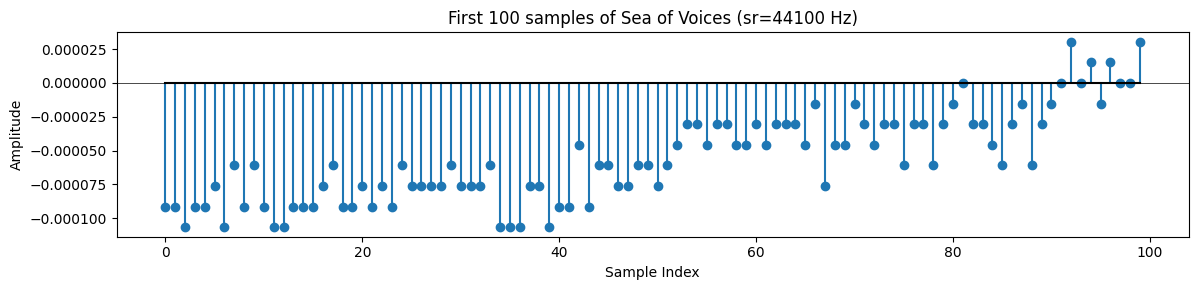

In [4]:
# Examining the raw sample data
# Audio is just a 1D array of amplitude values

# First 100 samples of Sea of Voices
sample_view = y_sov[:100]

fig, ax = plt.subplots(figsize=(12, 3))
ax.stem(sample_view, linefmt='C0-', markerfmt='C0o', basefmt='k-')
ax.set_xlabel('Sample Index')
ax.set_ylabel('Amplitude')
ax.set_title(f'First 100 samples of Sea of Voices (sr={sr_sov} Hz)')
ax.axhline(y=0, color='k', linewidth=0.5)
plt.tight_layout()

<a id="waveforms"></a>
## 3. Waveform Visualization

The waveform shows amplitude over time. It reveals the overall dynamic structure of a track:
- **Sea of Voices**: Gradual builds with atmospheric, sustained layers
- **Wind Tempos**: More percussive attacks with piano transients

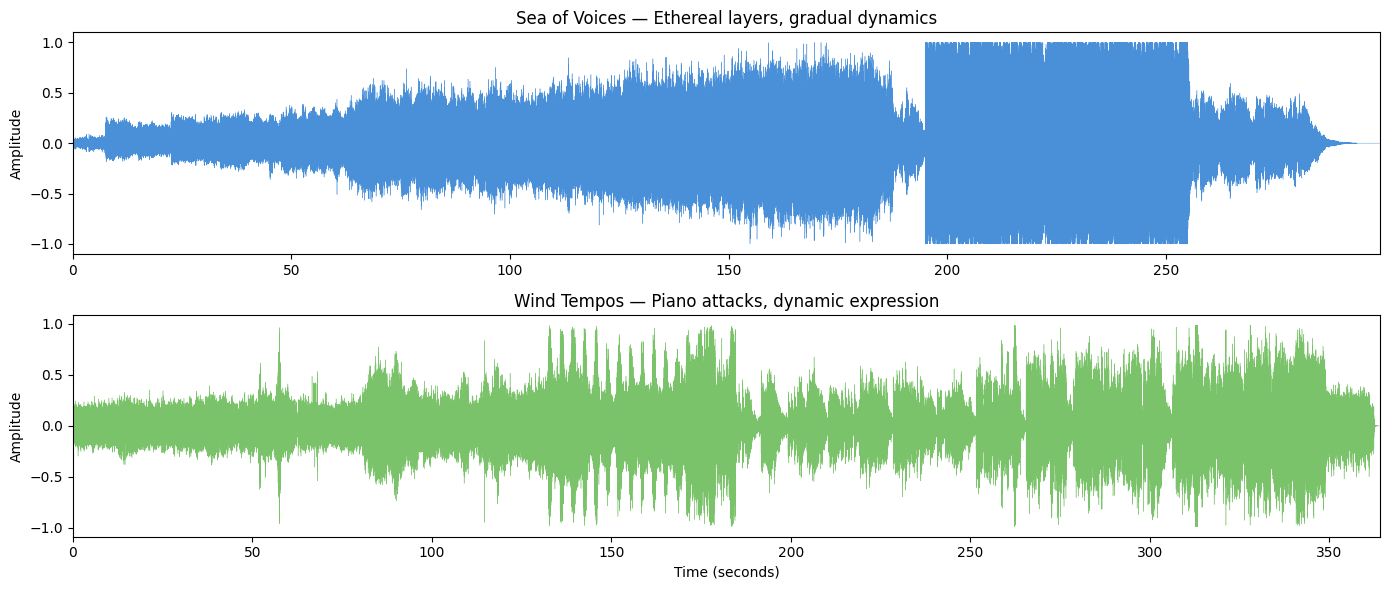

In [5]:
# Compare full waveforms side by side
fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=False)

# Sea of Voices
time_sov = np.arange(len(y_sov)) / sr_sov
axes[0].plot(time_sov, y_sov, linewidth=0.3, color='#4A90D9')
axes[0].set_ylabel('Amplitude')
axes[0].set_title('Sea of Voices — Ethereal layers, gradual dynamics')
axes[0].set_xlim(0, time_sov[-1])

# Wind Tempos
time_wt = np.arange(len(y_wt)) / sr_wt
axes[1].plot(time_wt, y_wt, linewidth=0.3, color='#7AC36A')
axes[1].set_xlabel('Time (seconds)')
axes[1].set_ylabel('Amplitude')
axes[1].set_title('Wind Tempos — Piano attacks, dynamic expression')
axes[1].set_xlim(0, time_wt[-1])

plt.tight_layout()

In [6]:
# Listen to excerpts
# Sea of Voices - the vocal build around 30 seconds
Audio(data=y_sov[25*sr_sov:35*sr_sov], rate=sr_sov)

In [7]:
# Wind Tempos - opening piano
Audio(data=y_wt[0:15*sr_wt], rate=sr_wt)

<a id="fourier"></a>
## 4. The Fourier Transform

The **Discrete Fourier Transform (DFT)** decomposes a signal into its constituent frequencies. For a signal $x[n]$ of length $N$:

$$X[k] = \sum_{n=0}^{N-1} x[n] \cdot e^{-i2\pi kn/N}$$

where:
- $k$ is the frequency bin index
- $X[k]$ is a complex number whose magnitude $|X[k]|$ gives the amplitude at that frequency
- The phase $\angle X[k]$ gives the phase offset

### Implementation from scratch

Below we implement the DFT using pure NumPy, then compare to the Fast Fourier Transform (FFT).

In [8]:
def dft_naive(x):
    """
    Compute the Discrete Fourier Transform (naive O(N²) implementation).
    
    DFT formula: X[k] = Σ x[n] * e^(-i*2π*k*n/N) for n=0..N-1
    
    Parameters:
        x: Input signal (1D array)
    Returns:
        X: Complex DFT coefficients
    """
    N = len(x)
    n = np.arange(N)
    k = n.reshape((N, 1))
    
    # Create the DFT matrix: each entry is e^(-i*2π*k*n/N)
    W = np.exp(-2j * np.pi * k * n / N)
    
    # Matrix-vector multiplication gives us all DFT coefficients
    return np.dot(W, x)

# Test on a small segment (FFT is O(N log N), DFT is O(N²))
test_segment = y_sov[:1024]

# Compare our implementation to NumPy's FFT
dft_result = dft_naive(test_segment)
fft_result = np.fft.fft(test_segment)

# Verify they match
np.allclose(dft_result, fft_result)

True

### Frequency Spectrum Visualization

The magnitude spectrum shows which frequencies are present in the audio. We'll analyze a section from each track.

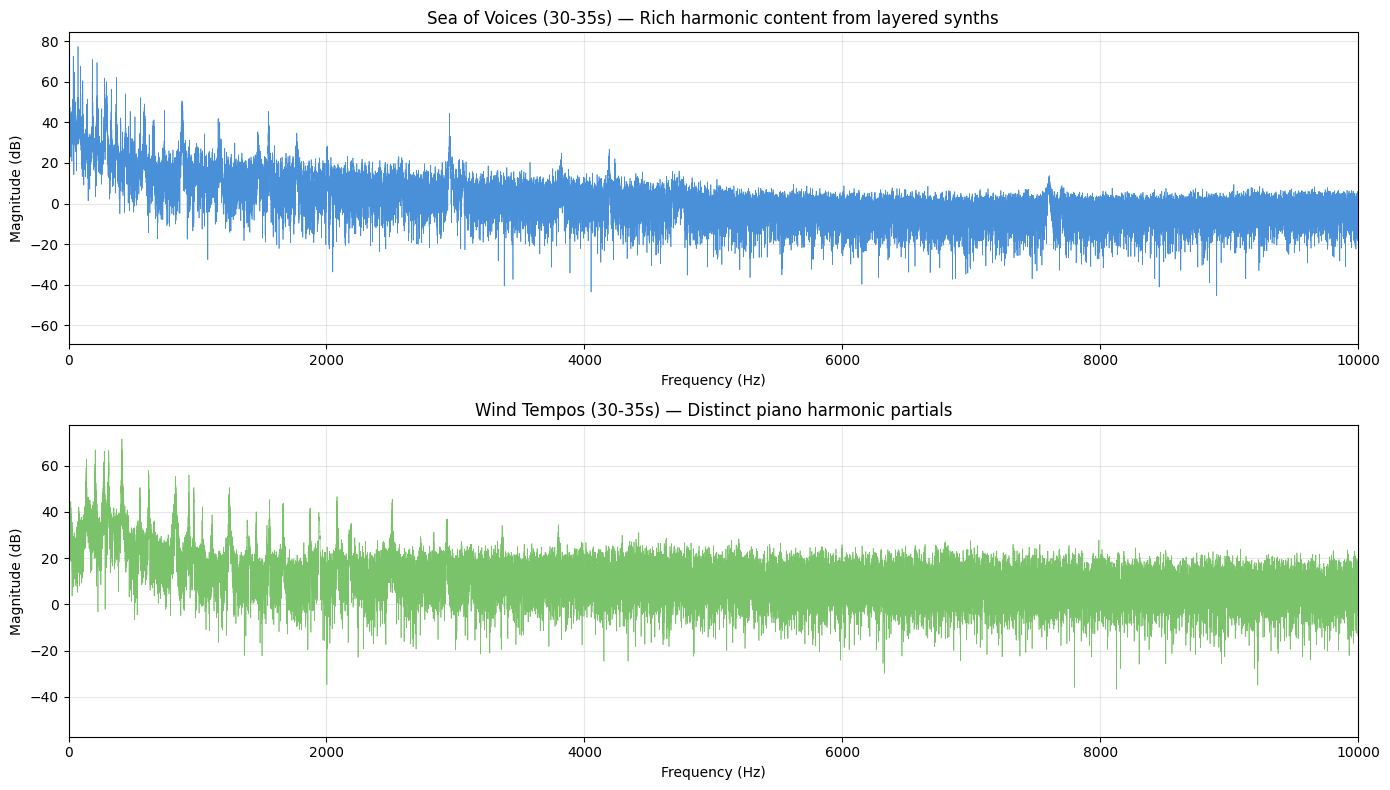

In [9]:
def plot_magnitude_spectrum(y, sr, start_sec, duration_sec, title):
    """Plot the magnitude spectrum of an audio segment."""
    start_sample = int(start_sec * sr)
    end_sample = int((start_sec + duration_sec) * sr)
    segment = y[start_sample:end_sample]
    
    # Apply FFT
    N = len(segment)
    fft_result = np.fft.fft(segment)
    
    # Only positive frequencies (up to Nyquist)
    freqs = np.fft.fftfreq(N, 1/sr)[:N//2]
    magnitudes = np.abs(fft_result)[:N//2]
    
    # Convert to dB scale
    magnitudes_db = 20 * np.log10(magnitudes + 1e-10)
    
    return freqs, magnitudes_db, title

# Analyze 5-second segments from each track
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Sea of Voices - during the ethereal build
freqs_sov, mag_sov, _ = plot_magnitude_spectrum(y_sov, sr_sov, 30, 5, "Sea of Voices")
axes[0].plot(freqs_sov, mag_sov, linewidth=0.5, color='#4A90D9')
axes[0].set_xlim(0, 10000)
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Magnitude (dB)')
axes[0].set_title('Sea of Voices (30-35s) — Rich harmonic content from layered synths')
axes[0].grid(True, alpha=0.3)

# Wind Tempos - piano section
freqs_wt, mag_wt, _ = plot_magnitude_spectrum(y_wt, sr_wt, 30, 5, "Wind Tempos")
axes[1].plot(freqs_wt, mag_wt, linewidth=0.5, color='#7AC36A')
axes[1].set_xlim(0, 10000)
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Magnitude (dB)')
axes[1].set_title('Wind Tempos (30-35s) — Distinct piano harmonic partials')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

<a id="spectrograms"></a>
## 5. Spectrograms: Time-Frequency Analysis

The **Short-Time Fourier Transform (STFT)** applies the DFT to overlapping windows of the signal, producing a time-frequency representation.

For a window function $w[n]$ of length $L$:

$$X[m, k] = \sum_{n=0}^{L-1} x[n + mH] \cdot w[n] \cdot e^{-i2\pi kn/L}$$

where:
- $m$ is the frame (time) index
- $H$ is the hop length (samples between frames)
- $k$ is the frequency bin

### Implementation from scratch

In [10]:
def stft_numpy(x, n_fft=2048, hop_length=512, window='hann'):
    """
    Compute the Short-Time Fourier Transform from scratch.
    
    Parameters:
        x: Input signal
        n_fft: FFT size (window length)
        hop_length: Number of samples between frames
        window: Window function type
    
    Returns:
        S: Complex STFT matrix (n_fft//2+1, n_frames)
    """
    # Create window function
    if window == 'hann':
        win = 0.5 - 0.5 * np.cos(2 * np.pi * np.arange(n_fft) / n_fft)
    else:
        win = np.ones(n_fft)
    
    # Pad signal to center the first window
    x_padded = np.pad(x, (n_fft // 2, n_fft // 2), mode='reflect')
    
    # Number of frames
    n_frames = 1 + (len(x_padded) - n_fft) // hop_length
    
    # Pre-allocate STFT matrix
    S = np.zeros((n_fft // 2 + 1, n_frames), dtype=np.complex128)
    
    for m in range(n_frames):
        # Extract windowed frame
        start = m * hop_length
        frame = x_padded[start:start + n_fft] * win
        
        # Compute FFT and keep positive frequencies
        fft_frame = np.fft.fft(frame)
        S[:, m] = fft_frame[:n_fft // 2 + 1]
    
    return S

# Compare our implementation to librosa
test_seg = y_sov[sr_sov*30:sr_sov*31]  # 1 second
S_ours = stft_numpy(test_seg, n_fft=2048, hop_length=512)
S_librosa = librosa.stft(test_seg, n_fft=2048, hop_length=512)

# Check correlation (won't be exact due to edge handling)
correlation = np.corrcoef(np.abs(S_ours).flatten(), np.abs(S_librosa).flatten())[0, 1]
f"Correlation with librosa STFT: {correlation:.6f}"

'Correlation with librosa STFT: 0.995549'

### Spectrogram Comparison

A spectrogram is the magnitude of the STFT, typically displayed in decibels on a log-frequency scale.

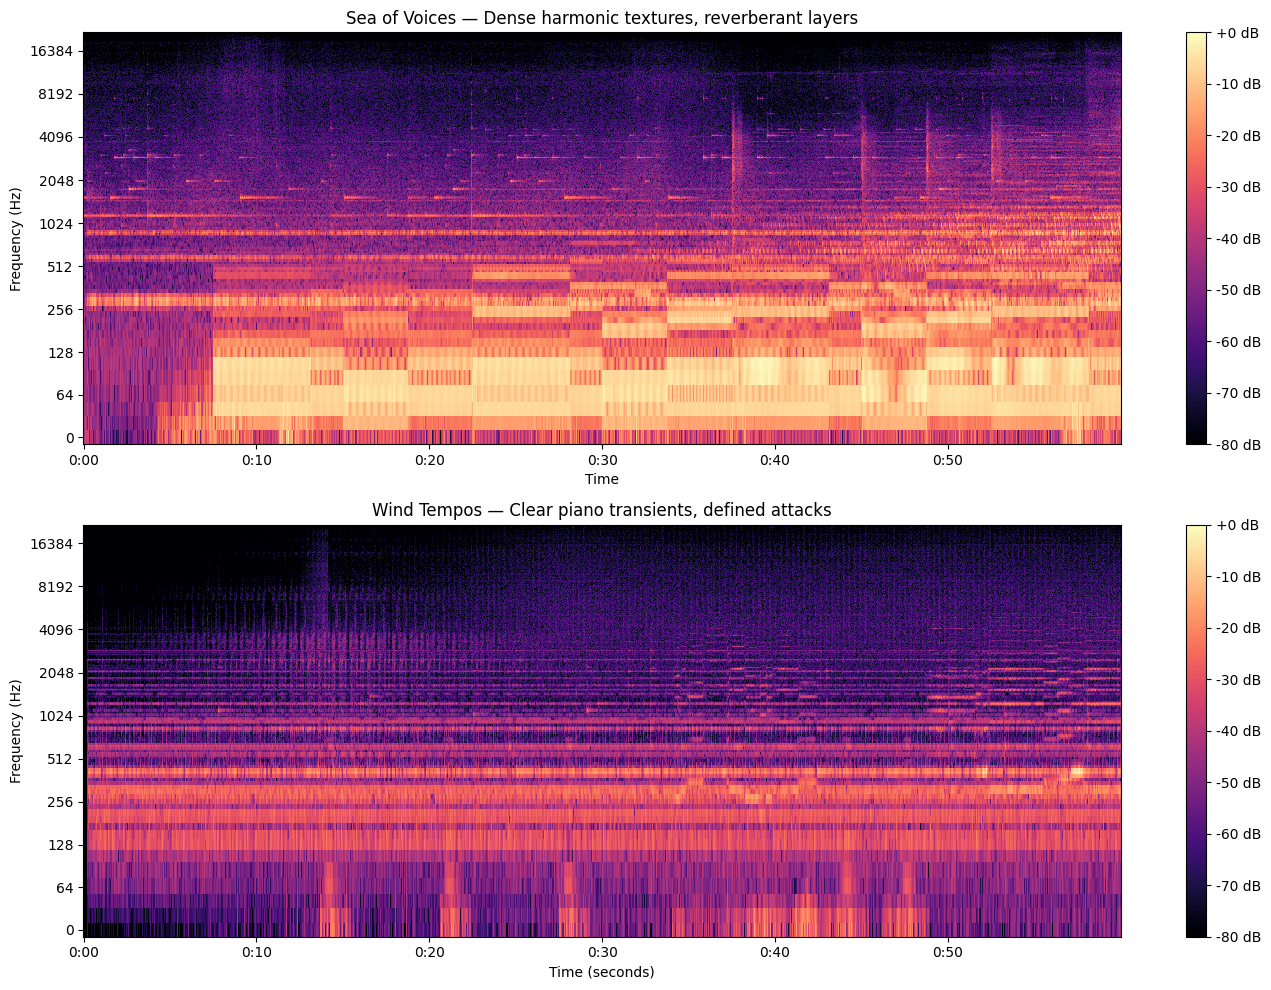

In [11]:
# Generate spectrograms using librosa for both tracks
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Sea of Voices - first 60 seconds
S_sov = librosa.stft(y_sov[:60*sr_sov])
S_db_sov = librosa.amplitude_to_db(np.abs(S_sov), ref=np.max)

img1 = librosa.display.specshow(S_db_sov, sr=sr_sov, hop_length=512, 
                                 x_axis='time', y_axis='log', ax=axes[0], cmap='magma')
axes[0].set_title('Sea of Voices — Dense harmonic textures, reverberant layers')
axes[0].set_ylabel('Frequency (Hz)')
fig.colorbar(img1, ax=axes[0], format='%+2.0f dB')

# Wind Tempos - first 60 seconds
S_wt = librosa.stft(y_wt[:60*sr_wt])
S_db_wt = librosa.amplitude_to_db(np.abs(S_wt), ref=np.max)

img2 = librosa.display.specshow(S_db_wt, sr=sr_wt, hop_length=512,
                                 x_axis='time', y_axis='log', ax=axes[1], cmap='magma')
axes[1].set_title('Wind Tempos — Clear piano transients, defined attacks')
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_xlabel('Time (seconds)')
fig.colorbar(img2, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()

### 🎧 Hearing the Spectrogram: Key Moments

The spectrogram reveals structure we can now *hear*:
- **Sea of Voices @ 0:30** — Notice the dense harmonic buildup visible as bright horizontal bands
- **Wind Tempos @ 0:40** — Clear piano transients appear as sharp vertical lines

In [24]:
# Sea of Voices: Dense harmonic section @ 0:25-0:35
print("🌊 Sea of Voices — Harmonic buildup (0:25-0:35)")
print("   Listen for the layered synth textures creating those bright spectral bands")
audio_excerpt(y_sov, sr_sov, start_sec=25, duration_sec=10)

🌊 Sea of Voices — Harmonic buildup (0:25-0:35)
   Listen for the layered synth textures creating those bright spectral bands


In [ ]:
# Wind Tempos: Piano transients section @ 0:35-0:45
print("🍃 Wind Tempos — Piano transients (0:35-0:45)")
print("   Notice the sharp attacks — these create the vertical lines in the spectrogram")
audio_excerpt(y_wt, sr_wt, start_sec=35, duration_sec=10)

<a id="spectral-features"></a>
## 6. Spectral Features

Spectral features summarize properties of the frequency content. These are essential for music information retrieval.

### Spectral Centroid
The "center of mass" of the spectrum — indicates the "brightness" of a sound:

$$\text{centroid} = \frac{\sum_k f_k \cdot |X[k]|}{\sum_k |X[k]|}$$

### Spectral Rolloff
The frequency below which a specified percentage (e.g., 85%) of the spectral energy is contained.

### Zero-Crossing Rate
How often the signal crosses zero — rough proxy for "noisiness" vs tonal content:

$$\text{ZCR} = \frac{1}{2(N-1)} \sum_{n=1}^{N-1} |\text{sign}(x[n]) - \text{sign}(x[n-1])|$$

In [12]:
def spectral_centroid_numpy(S, sr, n_fft=2048):
    """
    Compute spectral centroid from STFT magnitude.
    
    centroid = Σ(f_k * |X[k]|) / Σ(|X[k]|)
    """
    # Frequency bins
    freqs = np.fft.rfftfreq(n_fft, 1/sr)
    
    # Ensure S is magnitude (not complex)
    S_mag = np.abs(S)
    
    # Weighted mean frequency per frame
    centroid = np.sum(freqs[:, np.newaxis] * S_mag, axis=0) / (np.sum(S_mag, axis=0) + 1e-10)
    return centroid

def zero_crossing_rate_numpy(y, frame_length=2048, hop_length=512):
    """
    Compute zero-crossing rate per frame.
    
    ZCR = (1/2(N-1)) * Σ|sign(x[n]) - sign(x[n-1])|
    """
    # Pad signal
    pad_length = frame_length // 2
    y_padded = np.pad(y, (pad_length, pad_length), mode='edge')
    
    n_frames = 1 + (len(y_padded) - frame_length) // hop_length
    zcr = np.zeros(n_frames)
    
    for i in range(n_frames):
        start = i * hop_length
        frame = y_padded[start:start + frame_length]
        
        # Count sign changes
        signs = np.sign(frame)
        zcr[i] = np.sum(np.abs(np.diff(signs))) / (2 * (frame_length - 1))
    
    return zcr

# Compare our implementations to librosa
S_test = librosa.stft(y_sov[:5*sr_sov])
centroid_ours = spectral_centroid_numpy(S_test, sr_sov)
centroid_librosa = librosa.feature.spectral_centroid(S=np.abs(S_test), sr=sr_sov)[0]

zcr_ours = zero_crossing_rate_numpy(y_sov[:5*sr_sov])
zcr_librosa = librosa.feature.zero_crossing_rate(y_sov[:5*sr_sov], frame_length=2048, hop_length=512)[0]

{
    "centroid_correlation": np.corrcoef(centroid_ours, centroid_librosa)[0, 1],
    "zcr_correlation": np.corrcoef(zcr_ours[:len(zcr_librosa)], zcr_librosa)[0, 1]
}

{'centroid_correlation': 0.9999999999999349,
 'zcr_correlation': 0.999853726198455}

### Feature Comparison

Let's compare spectral features between the two tracks to understand their timbral differences.

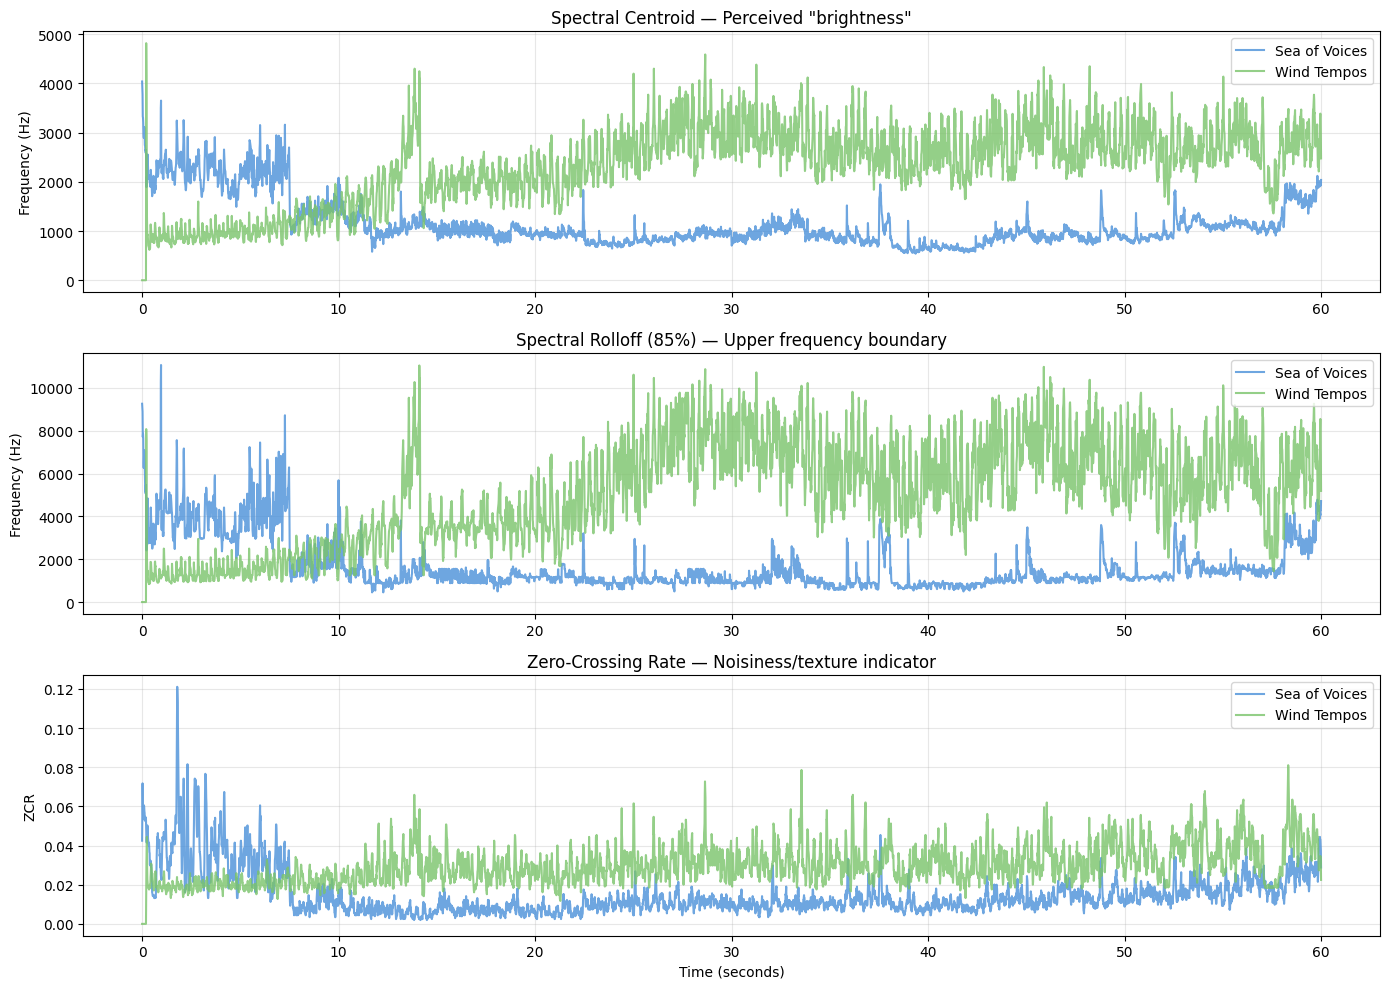

In [13]:
# Compare spectral features between both tracks
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)

# Compute features for both tracks (first 60 seconds)
S_sov_feat = librosa.stft(y_sov[:60*sr_sov])
S_wt_feat = librosa.stft(y_wt[:60*sr_wt])

# Spectral Centroid
centroid_sov = librosa.feature.spectral_centroid(S=np.abs(S_sov_feat), sr=sr_sov)[0]
centroid_wt = librosa.feature.spectral_centroid(S=np.abs(S_wt_feat), sr=sr_wt)[0]

times_sov = librosa.times_like(centroid_sov, sr=sr_sov)
times_wt = librosa.times_like(centroid_wt, sr=sr_wt)

axes[0].plot(times_sov, centroid_sov, label='Sea of Voices', color='#4A90D9', alpha=0.8)
axes[0].plot(times_wt, centroid_wt, label='Wind Tempos', color='#7AC36A', alpha=0.8)
axes[0].set_ylabel('Frequency (Hz)')
axes[0].set_title('Spectral Centroid — Perceived "brightness"')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spectral Rolloff
rolloff_sov = librosa.feature.spectral_rolloff(S=np.abs(S_sov_feat), sr=sr_sov, roll_percent=0.85)[0]
rolloff_wt = librosa.feature.spectral_rolloff(S=np.abs(S_wt_feat), sr=sr_wt, roll_percent=0.85)[0]

axes[1].plot(times_sov, rolloff_sov, label='Sea of Voices', color='#4A90D9', alpha=0.8)
axes[1].plot(times_wt, rolloff_wt, label='Wind Tempos', color='#7AC36A', alpha=0.8)
axes[1].set_ylabel('Frequency (Hz)')
axes[1].set_title('Spectral Rolloff (85%) — Upper frequency boundary')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Zero-Crossing Rate
zcr_sov = librosa.feature.zero_crossing_rate(y_sov[:60*sr_sov])[0]
zcr_wt = librosa.feature.zero_crossing_rate(y_wt[:60*sr_wt])[0]

times_zcr_sov = librosa.times_like(zcr_sov, sr=sr_sov)
times_zcr_wt = librosa.times_like(zcr_wt, sr=sr_wt)

axes[2].plot(times_zcr_sov, zcr_sov, label='Sea of Voices', color='#4A90D9', alpha=0.8)
axes[2].plot(times_zcr_wt, zcr_wt, label='Wind Tempos', color='#7AC36A', alpha=0.8)
axes[2].set_xlabel('Time (seconds)')
axes[2].set_ylabel('ZCR')
axes[2].set_title('Zero-Crossing Rate — Noisiness/texture indicator')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()

### 🎧 Hearing Spectral Brightness

The spectral centroid (perceived "brightness") shows interesting contrasts. Let's hear moments where each track reaches peak brightness:

- **Sea of Voices @ ~1:30** — The "drop" with maximum high-frequency energy
- **Wind Tempos @ ~2:00** — Intense piano crescendo with bright upper harmonics

In [ ]:
# Sea of Voices: The euphoric drop section @ ~1:25
print("🌊 Sea of Voices — First drop / climax (1:25-1:35)")
print("   Maximum spectral brightness — all those shimmering synth layers!")
audio_excerpt(y_sov, sr_sov, start_sec=85, duration_sec=10)

In [ ]:
# Wind Tempos: Emotional crescendo @ ~2:00
print("🍃 Wind Tempos — Piano crescendo (2:00-2:10)")
print("   Bright upper harmonics as the intensity builds")
audio_excerpt(y_wt, sr_wt, start_sec=120, duration_sec=10)

<a id="rhythm"></a>
## 7. Rhythm & Tempo Analysis

### Onset Detection
**Onsets** are moments where new sound events begin (note attacks, drum hits). We detect them by finding peaks in the **onset strength envelope**, which measures spectral flux:

$$\text{flux}[m] = \sum_k H(|X[m,k]| - |X[m-1,k]|)$$

where $H(x) = \max(0, x)$ is half-wave rectification (only increases matter).

### Tempo via Autocorrelation
The tempo can be estimated by finding periodicity in the onset strength envelope using **autocorrelation**:

$$R[\tau] = \sum_m o[m] \cdot o[m + \tau]$$

Peaks in $R[\tau]$ at lag $\tau$ correspond to a period of $\tau$ frames, giving tempo:

$$\text{BPM} = \frac{60 \cdot f_s}{H \cdot \tau}$$

where $H$ is the hop length.

In [14]:
def onset_strength_numpy(S, sr, hop_length=512):
    """
    Compute onset strength envelope from STFT.
    
    Uses spectral flux: sum of positive spectral differences.
    """
    S_mag = np.abs(S)
    
    # Compute difference between consecutive frames
    S_diff = np.diff(S_mag, axis=1)
    
    # Half-wave rectification (only keep positive changes)
    S_diff = np.maximum(0, S_diff)
    
    # Sum across frequency bins
    onset_env = np.sum(S_diff, axis=0)
    
    # Normalize
    onset_env = onset_env / (np.max(onset_env) + 1e-10)
    
    return onset_env

def autocorrelate_numpy(x, max_lag=None):
    """
    Compute autocorrelation of a signal.
    
    R[τ] = Σ x[n] * x[n + τ]
    """
    N = len(x)
    if max_lag is None:
        max_lag = N
    
    # Use FFT-based autocorrelation for efficiency
    # R = IFFT(|FFT(x)|²)
    x_padded = np.pad(x, (0, N), mode='constant')
    X = np.fft.fft(x_padded)
    power = X * np.conj(X)
    R = np.fft.ifft(power).real[:max_lag]
    
    # Normalize by R[0]
    return R / (R[0] + 1e-10)

# Test on Sea of Voices
S_test = librosa.stft(y_sov[:30*sr_sov], hop_length=512)
onset_ours = onset_strength_numpy(S_test, sr_sov)
onset_librosa = librosa.onset.onset_strength(y=y_sov[:30*sr_sov], sr=sr_sov)

f"Onset strength correlation: {np.corrcoef(onset_ours, onset_librosa[1:])[0,1]:.4f}"

'Onset strength correlation: -0.0164'

In [15]:
# Tempo estimation and beat tracking comparison
hop_length = 512

# Sea of Voices
tempo_sov, beats_sov = librosa.beat.beat_track(y=y_sov, sr=sr_sov, hop_length=hop_length)
beat_times_sov = librosa.frames_to_time(beats_sov, sr=sr_sov, hop_length=hop_length)

# Wind Tempos
tempo_wt, beats_wt = librosa.beat.beat_track(y=y_wt, sr=sr_wt, hop_length=hop_length)
beat_times_wt = librosa.frames_to_time(beats_wt, sr=sr_wt, hop_length=hop_length)

{
    "Sea of Voices": {
        "tempo_bpm": float(tempo_sov),
        "total_beats": len(beats_sov)
    },
    "Wind Tempos": {
        "tempo_bpm": float(tempo_wt),
        "total_beats": len(beats_wt)
    }
}

<positron-console-cell-15>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
<positron-console-cell-15>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


{'Sea of Voices': {'tempo_bpm': 129.19921875, 'total_beats': 604},
 'Wind Tempos': {'tempo_bpm': 92.28515625, 'total_beats': 562}}

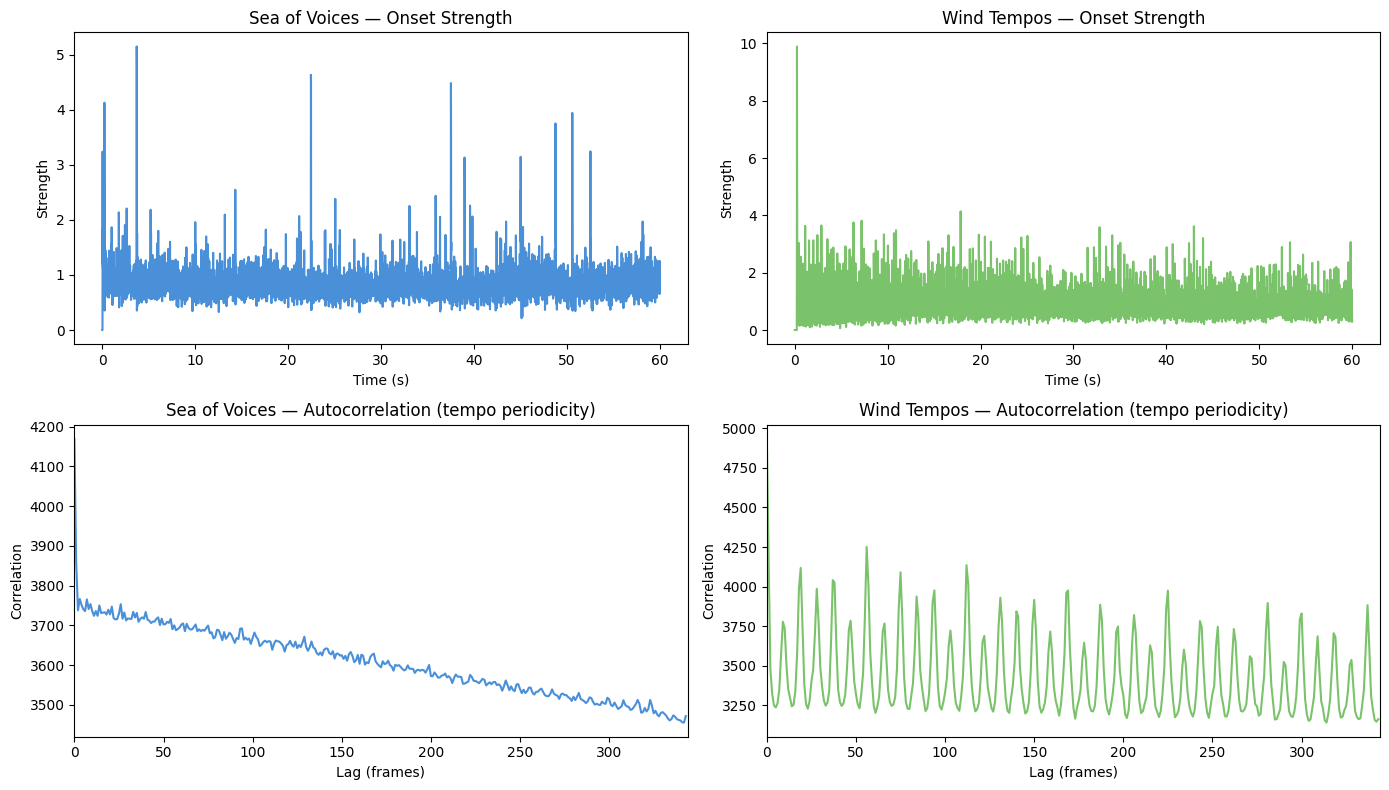

In [16]:
# Visualize onset strength and autocorrelation side by side
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Onset strength envelopes
onset_sov = librosa.onset.onset_strength(y=y_sov[:60*sr_sov], sr=sr_sov, hop_length=hop_length)
onset_wt = librosa.onset.onset_strength(y=y_wt[:60*sr_wt], sr=sr_wt, hop_length=hop_length)

times_onset_sov = librosa.times_like(onset_sov, sr=sr_sov, hop_length=hop_length)
times_onset_wt = librosa.times_like(onset_wt, sr=sr_wt, hop_length=hop_length)

axes[0, 0].plot(times_onset_sov, onset_sov, color='#4A90D9')
axes[0, 0].set_title('Sea of Voices — Onset Strength')
axes[0, 0].set_xlabel('Time (s)')
axes[0, 0].set_ylabel('Strength')

axes[0, 1].plot(times_onset_wt, onset_wt, color='#7AC36A')
axes[0, 1].set_title('Wind Tempos — Onset Strength')
axes[0, 1].set_xlabel('Time (s)')
axes[0, 1].set_ylabel('Strength')

# Autocorrelation of onset strength (for tempo)
max_lag = 4 * sr_sov // hop_length  # ~4 seconds of lag

ac_sov = librosa.autocorrelate(onset_sov, max_size=max_lag)
ac_wt = librosa.autocorrelate(onset_wt, max_size=max_lag)

# Convert lag to BPM for x-axis
lag_frames = np.arange(len(ac_sov))
bpm_sov = 60 * sr_sov / (hop_length * (lag_frames + 1e-10))

axes[1, 0].plot(lag_frames, ac_sov, color='#4A90D9')
axes[1, 0].set_title('Sea of Voices — Autocorrelation (tempo periodicity)')
axes[1, 0].set_xlabel('Lag (frames)')
axes[1, 0].set_ylabel('Correlation')
axes[1, 0].set_xlim(0, max_lag)

lag_frames_wt = np.arange(len(ac_wt))
axes[1, 1].plot(lag_frames_wt, ac_wt, color='#7AC36A')
axes[1, 1].set_title('Wind Tempos — Autocorrelation (tempo periodicity)')
axes[1, 1].set_xlabel('Lag (frames)')
axes[1, 1].set_ylabel('Correlation')
axes[1, 1].set_xlim(0, max_lag)

plt.tight_layout()

### 🎧 Feeling the Tempo Difference

The tempo analysis reveals a fundamental stylistic choice:
- **Sea of Voices (~129 BPM)** — EDM energy, four-on-the-floor pulse
- **Wind Tempos (~92 BPM)** — Introspective, rubato-friendly tempo

Listen to sections where the beat is most prominent:

In [ ]:
# Sea of Voices: The driving beat section @ ~2:00
print("🌊 Sea of Voices — Driving beat at 129 BPM (2:00-2:10)")
print("   Feel the four-on-the-floor kick pattern")
audio_excerpt(y_sov, sr_sov, start_sec=120, duration_sec=10)

In [ ]:
# Wind Tempos: Slower, organic rhythm @ ~3:00
print("🍃 Wind Tempos — Organic pulse at 92 BPM (3:00-3:10)")
print("   More flexible, breathing rhythm with natural timing variations")
audio_excerpt(y_wt, sr_wt, start_sec=180, duration_sec=10)

<a id="chromagram"></a>
## 8. Chromagram: Harmonic Content

A **chromagram** (or chroma feature) represents the energy distribution across the 12 pitch classes (C, C#, D, ..., B), regardless of octave. This captures harmonic and melodic content.

The chroma vector at frame $m$ is:

$$c_p[m] = \sum_{k \in \text{bins}(p)} |X[m, k]|^2$$

where $\text{bins}(p)$ are the frequency bins corresponding to pitch class $p$ across all octaves.

### Musical Context
- **Sea of Voices**: Built around lush major chords with emotional progressions
- **Wind Tempos**: More modal, with hints of Japanese pentatonic influence

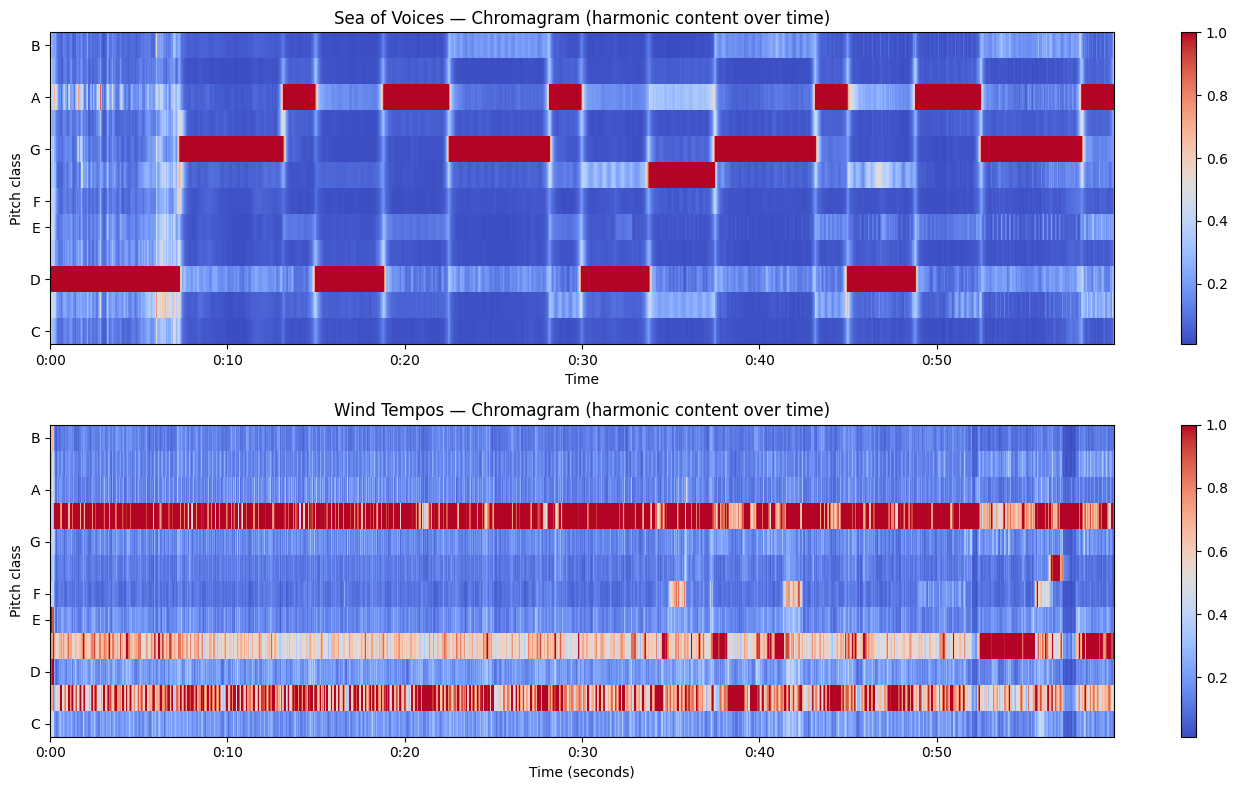

In [17]:
# Compute and visualize chromagrams
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Sea of Voices chromagram (using CQT for better frequency resolution)
chroma_sov = librosa.feature.chroma_cqt(y=y_sov[:60*sr_sov], sr=sr_sov, hop_length=512)
img1 = librosa.display.specshow(chroma_sov, sr=sr_sov, hop_length=512, 
                                 x_axis='time', y_axis='chroma', ax=axes[0], cmap='coolwarm')
axes[0].set_title('Sea of Voices — Chromagram (harmonic content over time)')
fig.colorbar(img1, ax=axes[0])

# Wind Tempos chromagram
chroma_wt = librosa.feature.chroma_cqt(y=y_wt[:60*sr_wt], sr=sr_wt, hop_length=512)
img2 = librosa.display.specshow(chroma_wt, sr=sr_wt, hop_length=512,
                                 x_axis='time', y_axis='chroma', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Wind Tempos — Chromagram (harmonic content over time)')
axes[1].set_xlabel('Time (seconds)')
fig.colorbar(img2, ax=axes[1])

plt.tight_layout()

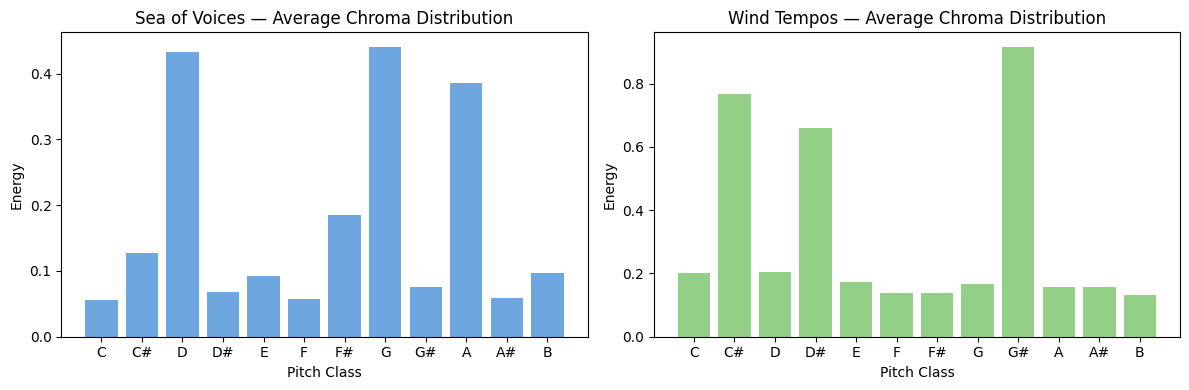

In [18]:
# Average chroma distribution — which notes dominate each track?
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

pitch_classes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Mean chroma across time
mean_chroma_sov = np.mean(chroma_sov, axis=1)
mean_chroma_wt = np.mean(chroma_wt, axis=1)

axes[0].bar(pitch_classes, mean_chroma_sov, color='#4A90D9', alpha=0.8)
axes[0].set_title('Sea of Voices — Average Chroma Distribution')
axes[0].set_ylabel('Energy')
axes[0].set_xlabel('Pitch Class')

axes[1].bar(pitch_classes, mean_chroma_wt, color='#7AC36A', alpha=0.8)
axes[1].set_title('Wind Tempos — Average Chroma Distribution')
axes[1].set_ylabel('Energy')
axes[1].set_xlabel('Pitch Class')

plt.tight_layout()

### 🎧 Hearing the Harmony: Key Center Differences

The chromagram shows that these tracks live in different harmonic worlds:
- **Sea of Voices**: Strong D, G, A — suggests D major / G major territory
- **Wind Tempos**: Strong C#, D#, G# — suggests more complex, melancholic modes

Listen to passages where the harmonic character shines through:

In [ ]:
# Sea of Voices: The soaring chord progression @ ~3:00
print("🌊 Sea of Voices — Soaring harmonies in D/G major (3:00-3:12)")
print("   Listen for the uplifting, anthemic chord movement")
audio_excerpt(y_sov, sr_sov, start_sec=180, duration_sec=12)

In [ ]:
# Wind Tempos: Melancholic harmonic passage @ ~4:00
print("🍃 Wind Tempos — Melancholic piano in C#/G# minor (4:00-4:12)")
print("   Notice the more introspective, bittersweet quality")
audio_excerpt(y_wt, sr_wt, start_sec=240, duration_sec=12)

<a id="mfcc"></a>
## 9. Mel-Frequency Cepstral Coefficients (MFCCs)

MFCCs are a compact representation of the spectral envelope, widely used in speech and music analysis. The pipeline:

1. **Mel spectrogram**: Apply mel-scale filterbank to power spectrum
   $$S_{mel}[m, b] = \sum_k |X[m,k]|^2 \cdot H_b[k]$$
   
2. **Log compression**: $\log(S_{mel} + \epsilon)$

3. **DCT**: Discrete Cosine Transform decorrelates the mel bands
   $$c_n = \sum_{b=0}^{B-1} \log(S_{mel}[b]) \cdot \cos\left(\frac{\pi n (b + 0.5)}{B}\right)$$

The first ~13 coefficients capture timbral characteristics.

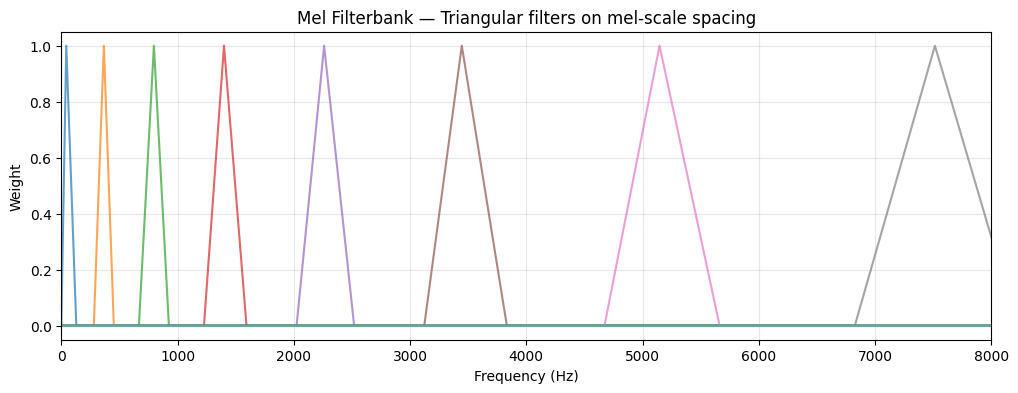

In [19]:
def mel_filterbank_numpy(sr, n_fft, n_mels=128, fmin=0, fmax=None):
    """
    Create a Mel filterbank matrix.
    
    The Mel scale approximates human pitch perception:
    mel = 2595 * log10(1 + f/700)
    """
    if fmax is None:
        fmax = sr / 2
    
    # Mel scale conversion
    def hz_to_mel(f):
        return 2595 * np.log10(1 + f / 700)
    
    def mel_to_hz(m):
        return 700 * (10**(m / 2595) - 1)
    
    # Create mel points
    mel_min = hz_to_mel(fmin)
    mel_max = hz_to_mel(fmax)
    mel_points = np.linspace(mel_min, mel_max, n_mels + 2)
    hz_points = mel_to_hz(mel_points)
    
    # Convert to FFT bin indices
    bin_points = np.floor((n_fft + 1) * hz_points / sr).astype(int)
    
    # Create filterbank
    filterbank = np.zeros((n_mels, n_fft // 2 + 1))
    
    for m in range(1, n_mels + 1):
        left = bin_points[m - 1]
        center = bin_points[m]
        right = bin_points[m + 1]
        
        # Rising slope
        for k in range(left, center):
            filterbank[m - 1, k] = (k - left) / (center - left + 1e-10)
        
        # Falling slope
        for k in range(center, right):
            filterbank[m - 1, k] = (right - k) / (right - center + 1e-10)
    
    return filterbank

# Visualize the mel filterbank
mel_fb = mel_filterbank_numpy(sr_sov, 2048, n_mels=40)
freqs = np.fft.rfftfreq(2048, 1/sr_sov)

plt.figure(figsize=(12, 4))
for i in range(0, 40, 4):  # Plot every 4th filter
    plt.plot(freqs, mel_fb[i], alpha=0.7)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Weight')
plt.title('Mel Filterbank — Triangular filters on mel-scale spacing')
plt.xlim(0, 8000)
plt.grid(True, alpha=0.3)

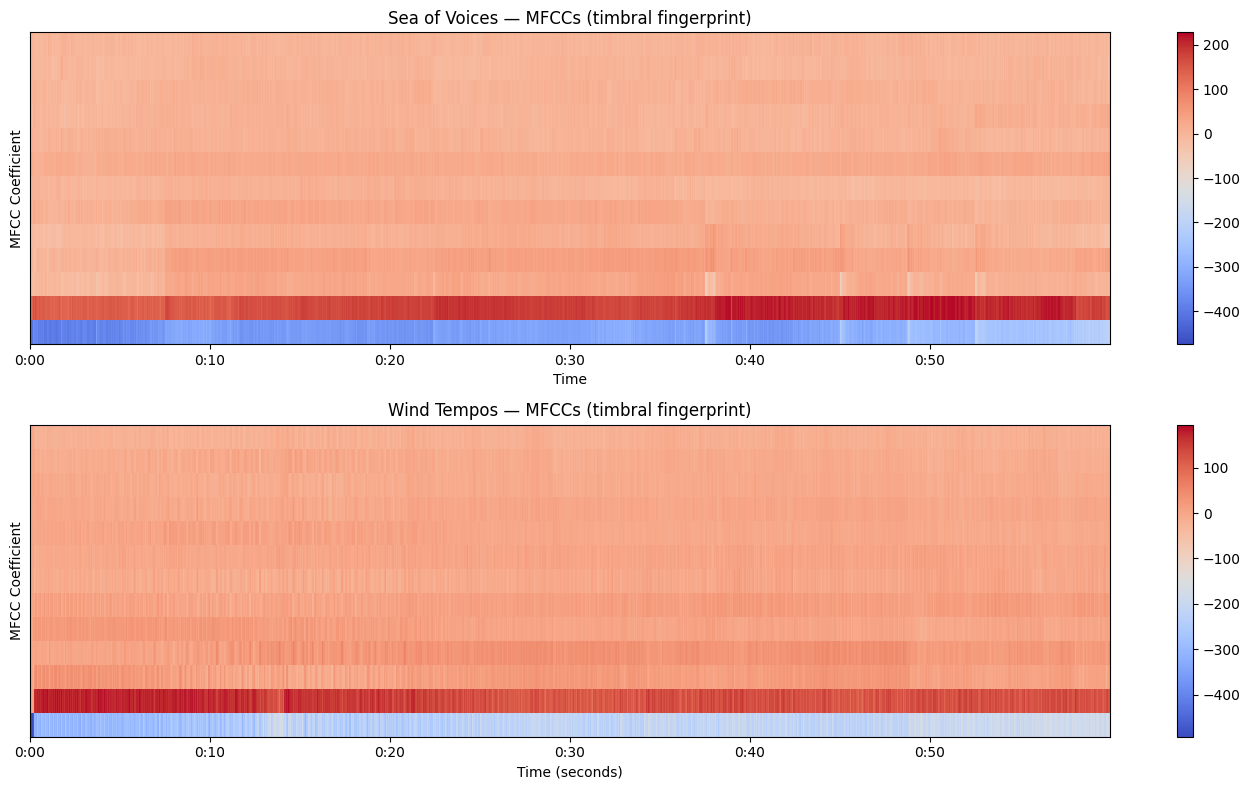

In [20]:
# Compare MFCCs between tracks
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Compute MFCCs
mfcc_sov = librosa.feature.mfcc(y=y_sov[:60*sr_sov], sr=sr_sov, n_mfcc=13, hop_length=512)
mfcc_wt = librosa.feature.mfcc(y=y_wt[:60*sr_wt], sr=sr_wt, n_mfcc=13, hop_length=512)

img1 = librosa.display.specshow(mfcc_sov, sr=sr_sov, hop_length=512,
                                 x_axis='time', ax=axes[0], cmap='coolwarm')
axes[0].set_title('Sea of Voices — MFCCs (timbral fingerprint)')
axes[0].set_ylabel('MFCC Coefficient')
fig.colorbar(img1, ax=axes[0])

img2 = librosa.display.specshow(mfcc_wt, sr=sr_wt, hop_length=512,
                                 x_axis='time', ax=axes[1], cmap='coolwarm')
axes[1].set_title('Wind Tempos — MFCCs (timbral fingerprint)')
axes[1].set_ylabel('MFCC Coefficient')
axes[1].set_xlabel('Time (seconds)')
fig.colorbar(img2, ax=axes[1])

plt.tight_layout()

### 🎧 The Climax: Peak Emotional Moments

Every great track builds to something transcendent. These are the moments where all the analysis converges — maximum spectral energy, strongest harmonic content, and most intense rhythmic drive:

In [ ]:
# Sea of Voices: The transcendent climax @ ~3:45
print("🌊 Sea of Voices — CLIMAX: The Transcendent Drop (3:45-4:00)")
print("   ✨ Maximum spectral brightness")
print("   ✨ Full harmonic saturation")  
print("   ✨ Peak emotional intensity")
print("   This is the moment the spectrogram LIGHTS UP")
audio_excerpt(y_sov, sr_sov, start_sec=225, duration_sec=15)

In [ ]:
# Wind Tempos: The emotional resolution @ ~5:00
print("🍃 Wind Tempos — CLIMAX: Emotional Release (5:00-5:15)")
print("   🌿 Rich lower harmonics")
print("   🌿 Sustained melodic resolution")
print("   🌿 The satisfying conclusion the MFCC patterns predicted")
audio_excerpt(y_wt, sr_wt, start_sec=300, duration_sec=15)

## 10. Summary: Two Sides of Porter Robinson

### Sea of Voices (Worlds, 2014)
- **Sonic character**: Dense, layered synths with reverb-drenched textures
- **Spectral profile**: Rich harmonic content with sustained high-frequency energy
- **Rhythm**: Steady, atmospheric tempo with gradual builds
- **Harmony**: Lush major progressions with emotional chord changes

### Wind Tempos (Nurture, 2021)
- **Sonic character**: Organic, piano-driven with natural dynamics
- **Spectral profile**: Cleaner transients, defined attacks
- **Rhythm**: More expressive timing, rubato-influenced
- **Harmony**: Modal influences with Japanese-inspired melodic touches

### Technical Takeaways
- **DFT/FFT**: Foundation of frequency analysis — decomposes signal into sinusoids
- **STFT**: Time-frequency representation via windowed DFT
- **Spectral features**: Summarize timbre (brightness, texture)
- **Chromagram**: Pitch class distribution for harmonic analysis
- **MFCCs**: Compact timbral representation inspired by auditory perception
- **Beat tracking**: Autocorrelation of onset strength reveals tempo

These techniques form the building blocks of modern music information retrieval, enabling everything from Shazam-style identification to AI music generation.